### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# install local geoopt first: !pip install -e data/geoopt
import geoopt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import spearmanr

import _utils
from _utils import set_all_seeds, set_plt_layout
from _utils import calculate_reconstruction_metrics
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

_utils.reset_plt_layout()
set_all_seeds(0); set_plt_layout()

### Loading data

In [3]:
# MIT License at https://github.com/emilemathieu/pvae/blob/master/LICENSE.md 
# Copyright (c) 2018 Emile Mathieu

class SyntheticDataset(torch.utils.data.Dataset):
    '''
    Implementation of a synthetic dataset by hierarchical diffusion. 
    Args:
    :param int dim: dimension of the input sample
    :param int depth: depth of the tree; the root corresponds to the depth 0
    :param int :numberOfChildren: Number of children of each node in the tree
    :param int :numberOfsiblings: Number of noisy observations obtained from the nodes of the tree
    :param float sigma_children: noise
    :param int param: integer by which :math:`\\sigma_children` is divided at each deeper level of the tree
    '''
    def __init__(self, dim, depth, numberOfChildren=2, sigma_children=1, param=1, numberOfsiblings=1, factor_sibling=10):
        self.dim = int(dim)
        self.root = np.zeros(self.dim)
        self.depth = int(depth)
        self.sigma_children = sigma_children
        self.factor_sibling = factor_sibling
        self.param = param
        self.numberOfChildren = int(numberOfChildren)
        self.numberOfsiblings = int(numberOfsiblings)  

        self.origin_data, self.origin_labels, self.data, self.labels = self.bst()

        # Normalise data (0 mean, 1 std)
        self.data -= np.mean(self.data, axis=0, keepdims=True)
        self.data /= np.std(self.data, axis=0, keepdims=True)

    def __len__(self):
        '''
        this method returns the total number of samples/nodes
        '''
        return len(self.data)

    def __getitem__(self, idx):
        '''
        Generates one sample
        '''
        data, labels = self.data[idx], self.labels[idx]
        return torch.Tensor(data), torch.Tensor(labels)

    def get_children(self, parent_value, parent_label, current_depth, offspring=True):
        '''
        :param 1d-array parent_value
        :param 1d-array parent_label
        :param int current_depth
        :param  Boolean offspring: if True the parent node gives birth to numberOfChildren nodes
                                    if False the parent node gives birth to numberOfsiblings noisy observations
        :return: list of 2-tuples containing the value and label of each child of a parent node
        :rtype: list of length numberOfChildren
        '''
        if offspring:
            numberOfChildren = self.numberOfChildren
            sigma = self.sigma_children / (self.param ** current_depth)
        else:
            numberOfChildren = self.numberOfsiblings
            sigma = self.sigma_children / (self.factor_sibling*(self.param ** current_depth))
        children = []
        for i in range (numberOfChildren):
            child_value = parent_value + np.random.randn(self.dim) * np.sqrt(sigma)
            child_label = np.copy(parent_label)
            if offspring: 
                child_label[current_depth] = i + 1
            else:
                child_label[current_depth] = -i - 1
            children.append((child_value, child_label))
        return children

    def bst(self):
        '''
        This method generates all the nodes of a level before going to the next level
        '''
        queue = [(self.root, np.zeros(self.depth+1), 0)]
        visited = []
        labels_visited = []
        values_clones = []
        labels_clones = []
        while len(queue) > 0:
            current_node, current_label, current_depth = queue.pop(0)
            visited.append(current_node)
            labels_visited.append(current_label)
            if current_depth < self.depth:
                children = self.get_children(current_node, current_label, current_depth)
                for child in children:
                    queue.append((child[0], child[1], current_depth + 1)) 
            if current_depth <= self.depth:
                clones = self.get_children(current_node, current_label, current_depth, False)
                for clone in clones:
                    values_clones.append(clone[0])
                    labels_clones.append(clone[1])
        length = int(((self.numberOfChildren) ** (self.depth + 1) - 1) / (self.numberOfChildren - 1))
        length_leaves = int(self.numberOfChildren**self.depth)
        images = np.concatenate([i for i in visited]).reshape(length, self.dim)
        labels_visited = np.concatenate([i for i in labels_visited]).reshape(length, self.depth+1)[:,:self.depth]
        values_clones = np.concatenate([i for i in values_clones]).reshape(self.numberOfsiblings*length, self.dim)
        labels_clones = np.concatenate([i for i in labels_clones]).reshape(self.numberOfsiblings*length, self.depth+1)
        return images, labels_visited, values_clones, labels_clones


In [4]:
set_all_seeds(0)

class Nodes(torch.utils.data.Dataset):
    def __init__(self, dataset, subset=None, labels=None, outer_labels=None, adj=None):
        super(Nodes, self).__init__()
        self.data = dataset[subset] if subset is not None else dataset
        if labels is not None: self.labels = labels[subset] if subset is not None else labels
        
        self.data = torch.tensor(self.data, dtype=torch.float64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return index, self.data[index], index

# Generate data 
data_size = 50 # dim of gaussian noise
data_params = [6, 2, 1, 1, 50, 8] 
dataset = SyntheticDataset(data_size, *map(lambda x: float(x), data_params))
print("Dataset shape:", dataset.data.shape)


device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

# Split data into train, validation and test sets (82/9/9)
indices = np.arange(len(dataset.data))
np.random.shuffle(indices)

train_size = int(0.82 * len(indices))
val_size = int(0.09 * len(indices))
test_size = len(indices) - train_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_data = Nodes(dataset.data, train_indices, dataset.labels)
val_data = Nodes(dataset.data, val_indices, dataset.labels)
test_data = Nodes(dataset.data, test_indices, dataset.labels)

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


Dataset shape: (6350, 50)


2025-05-22 19:08:54.891185: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 19:08:54.905487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-22 19:08:54.920187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-22 19:08:54.924641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-22 19:08:54.940215: I tensorflow/core/platform/cpu_feature_guar

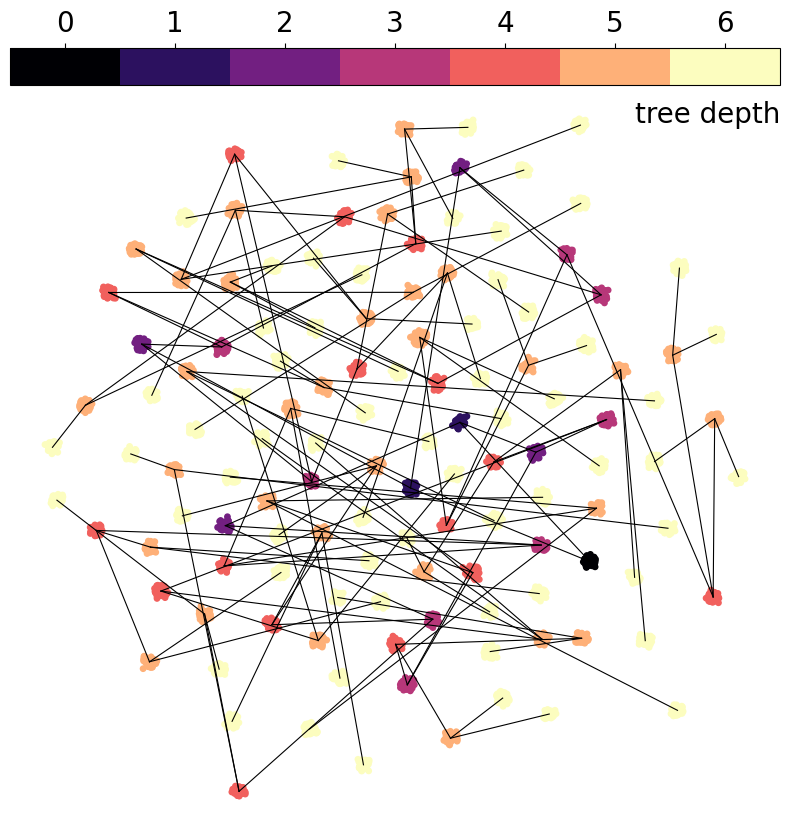

In [5]:
import umap

reducer = umap.UMAP(n_components=2, n_jobs=8, min_dist=0.99, n_neighbors=30)
umap_embeddings = reducer.fit_transform(train_data.data)

# build positive_labels & cluster assignments
l = train_data.labels * (train_data.labels >= 0)
unique_labels, label_indices = np.unique(l, axis=0, return_inverse=True)
ys = label_indices
ys = np.argmin(train_data.labels, axis=1)

positive_labels = np.where(l > 0, l, 0)
unique_labels, inverse_indices = np.unique(positive_labels, axis=0, return_inverse=True)

label_to_mean_pos = {}
for label in unique_labels:
    indices = np.where((positive_labels == label).all(axis=1))[0]
    if len(indices) > 0:
        mean_pos = umap_embeddings[indices].mean(axis=0)
        label_to_mean_pos[tuple(label)] = mean_pos

edges = []
for label in unique_labels:
    label_tuple = tuple(label)
    non_zero_indices = np.nonzero(label)[0]
    if len(non_zero_indices) > 0:
        last_non_zero = non_zero_indices[-1]
        parent_label = list(label)
        parent_label[last_non_zero] = 0
        parent_label_tuple = tuple(parent_label)
        if parent_label_tuple in label_to_mean_pos:
            edges.append((parent_label_tuple, label_tuple))


# Plotting 
fig, ax = plt.subplots(figsize=(8, 8.5))
sc = ax.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=ys,
    s=15,
    cmap='magma',
    alpha=1
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0)

num_clusters = len(np.unique(ys))
cbar = fig.colorbar(
    ax.collections[0], cax=cax,
    orientation='horizontal',
    boundaries=np.arange(num_clusters+1)-0.5,
    ticks=np.arange(num_clusters)
)
cbar.set_label("")
cax.text(
    1, -0.8, "tree depth",
    va='center', ha='right',
    fontsize=20, 
    transform=cax.transAxes,
    rotation=0
)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cbar.ax.set_xticks(np.arange(num_clusters))
cluster_labels = [str(i) for i in range(len(np.unique(ys)))]
cbar.ax.set_xticklabels(cluster_labels, fontsize=20) 
cbar.ax.tick_params(labelsize=20) 
cbar.ax.minorticks_off()

# draw edges
for p_lab, c_lab in edges:
    p_xy = label_to_mean_pos[p_lab]
    c_xy = label_to_mean_pos[c_lab]
    ax.plot([p_xy[0], c_xy[0]], [p_xy[1], c_xy[1]], 'k-', linewidth=0.8)

# ax.set_xlabel('UMAP 1')
# ax.set_ylabel('UMAP 2')

plt.tight_layout()
# plt.savefig('results/pdfs/final_synth_umap_cbar.pdf', format='pdf', dpi=300, bbox_inches='tight')
# plt.savefig('results/pngs/final_synth_umap_cbar.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

### Model definition

In [6]:
# ---------------------------------
# - Riemannian generative decoder - 
# ---------------------------------

class RGD(nn.Module):
    def __init__(self, dim_list, manifold=geoopt.manifolds.Euclidean()):
        super(RGD, self).__init__()
        self.dim_list = dim_list
        self.manifold = manifold 
        self.origin = self.manifold.origin(dim_list[0], seed=None, device=device)

        # fc decoder stack with swish activations 
        layers = []
        for i in range(len(dim_list) - 1):
            layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
            if i != len(dim_list) - 2: # only activations for hidden layers
                layers.append(nn.SiLU())
        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        return self.decoder(z)

    def init_samples(self, n):
        # manifold-projected points with small noise opposite origin 
        z = -torch.ones(n, self.dim_list[0], device=device) * self.origin
        z = self.manifold.projx(z)
        return geoopt.ManifoldParameter(z, manifold=self.manifold, requires_grad=True)

from _train import train_rgd
torch.set_default_dtype(torch.float64) 

In [ ]:
# define parameters 
device = "cuda:1"
dim_list = [3, 16, 32, 64, 128, 256, train_data.data.shape[1]]

c = 5; std = 0.5
manifold = geoopt.manifolds.Lorentz(k=c)

# initialize and train model
model = RGD(dim_list, manifold)
model.z = model.init_samples(len(train_data))
model.z_val = model.init_samples(len(val_data))
train_rgd(model, F.mse_loss, train_loader, val_loader, [2e-1, 2e-3], betas=(0.9, 0.995), 
    n_epochs=800, device=device, patience=85, start_saving=150, wd=1e-3, noise_std=std)

# find test-time representations 
loss_fn = lambda x, y: F.mse_loss(x, y, reduction='none')
ztest = _utils.get_representations(model, test_loader, loss_fn, n_start_points_per_sample=100, n_epochs=400, lr=3e-1, betas=(0.5, 0.7), wd=0, device=device)
model.z_test = ztest

### Evaluation

In [8]:
from scipy.stats import spearmanr

def tree_distance(label1: np.ndarray,
                  label2: np.ndarray) -> int:
    """
    Compute the tree‐distance between two nodes whose paths
    from the root are encoded in `label1` and `label2`.
    Handles noisy “clone” labels (negative entries).
    """
    # copy and ensure integer array
    l1 = np.asarray(label1, dtype=int).copy()
    l2 = np.asarray(label2, dtype=int).copy()

    # zero out any negative “sibling‐clone” tags
    l1[l1 < 0] = 0
    l2[l2 < 0] = 0

    # count actual steps (entries > 0) from root
    d1 = int((l1 > 0).sum())
    d2 = int((l2 > 0).sum())

    # find depth of lowest common ancestor
    common = 0
    for i in range(min(d1, d2)):
        if l1[i] == l2[i]:
            common += 1
        else:
            break

    # distance = steps up from node1 to LCA + steps down from LCA to node2
    return (d1 - common) + (d2 - common)

# Faster version for all-pairs tree-distance matrix
def pairwise_tree_distances(labels: np.ndarray) -> np.ndarray:
    """
    Fully-vectorized all-pairs tree-distance matrix over `labels`.
    """
    # 1) zero out negatives & cast
    L = np.maximum(0, labels.astype(int))          # (N, D)
    # 2) true depth of each sample
    depths = (L > 0).sum(axis=1)                   # (N,)
    # 3) build equality cube
    eq = (L[:, None, :] == L[None, :, :])          # (N, N, D)
    # 4) how many leading matches per pair
    pref = np.cumprod(eq.astype(int), axis=2)      # ones until first mismatch
    common = pref.sum(axis=2)                      # raw prefix lengths
    # 5) clamp by shallower depth
    md = np.minimum(depths[:, None], depths[None, :])
    common = np.minimum(common, md)
    # 6) assemble distances
    return depths[:, None] + depths[None, :] - 2 * common

def calculate_correlation_metrics_branching(z, manifold, dataset):
    """
    Computes Pearson/Spearman correlations between
      1) pairwise manifold distances of embeddings `z`
      2) the corresponding tree-distances from `dataset.labels`
    """
    N = len(z)
    triu_idx = np.triu_indices(N, k=1)

    # --- 1) manifold distances ---
    dist_matrix = np.zeros((N, N), dtype=float)
    for i in range(N):
        if (i + 1) % 100 == 0 or i == N - 1:
            print(f'Manifold distance progress: {i+1}/{N}', end='\r')
        with torch.no_grad():
            d = manifold.dist(z[i].unsqueeze(0), z) \
                       .detach() \
                       .cpu() \
                       .numpy() \
                       .squeeze()
        dist_matrix[i] = d
    rep_distances = dist_matrix[triu_idx]

    # --- 2) tree distances via helper function ---
    labels = dataset.labels    # shape (N, D)
    tree_matrix = pairwise_tree_distances(labels)
    tree_distances = tree_matrix[triu_idx]

    # --- 3) correlations ---
    pearson_corr = np.corrcoef(rep_distances, tree_distances)[0, 1]
    spearman_corr, _ = spearmanr(rep_distances, tree_distances)

    return pearson_corr, spearman_corr

In [9]:
# Compute results 
pearson, spearman = calculate_correlation_metrics_branching(model.z, manifold, train_data)
test_pearson, test_spearman = calculate_correlation_metrics_branching(model.z_test, manifold, test_data)
train_mae, train_mse = calculate_reconstruction_metrics(model, model.z, train_data)
test_mae, test_mse = calculate_reconstruction_metrics(model, model.z_test, test_data)
print(f"Train: Pearson={round(pearson, 3)}, Spearman={round(spearman, 3)}, MAE={round(train_mae, 3)}, MSE={round(train_mse, 3)}")
print(f" Test: Pearson={round(test_pearson, 3)}, Spearman={round(test_spearman, 3)}, MAE={round(test_mae, 3)}, MSE={round(test_mse, 3)}")

Train: Pearson=0.832, Spearman=0.803, MAE=0.308, MSE=0.157
 Test: Pearson=0.749, Spearman=0.753, MAE=0.263, MSE=0.115


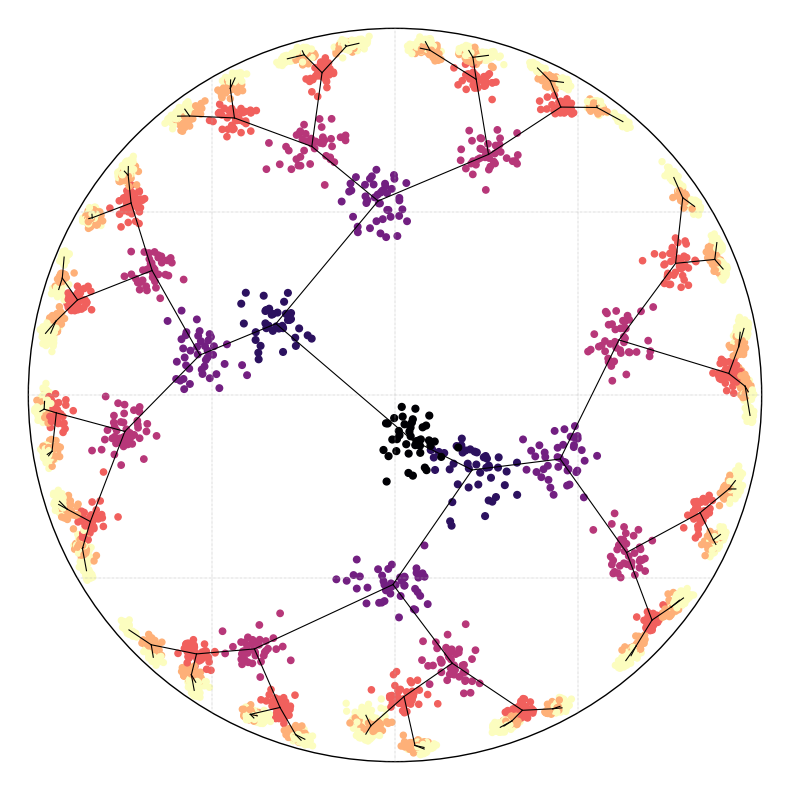

In [10]:
disk_radius = 1

def lorentz_to_poincare(z, k=c):
    return z[:, 1:] / (z[:, :1])

l = train_data.labels * (train_data.labels >= 0)
unique_labels, label_indices = np.unique(l, axis=0, return_inverse=True)
ys = label_indices
ys = np.argmin(train_data.labels, axis=1)

z_poincare = lorentz_to_poincare(model.z) if manifold.name == 'Lorentz' else model.z
z_poincare = z_poincare.data.cpu().numpy()

positive_labels = np.where(l > 0, l, 0)
unique_labels, inverse_indices = np.unique(positive_labels, axis=0, return_inverse=True)

label_to_mean_pos = {}
for label in unique_labels:
    indices = np.where((positive_labels == label).all(axis=1))[0]
    if len(indices) > 0:
        mean_pos = z_poincare[indices].mean(axis=0)
        label_to_mean_pos[tuple(label)] = mean_pos

edges = []
for label in unique_labels:
    label_tuple = tuple(label)
    non_zero_indices = np.nonzero(label)[0]
    if len(non_zero_indices) > 0:
        last_non_zero = non_zero_indices[-1]
        parent_label = list(label)
        parent_label[last_non_zero] = 0
        parent_label_tuple = tuple(parent_label)
        if parent_label_tuple in label_to_mean_pos:
            edges.append((parent_label_tuple, label_tuple))

set_plt_layout()

from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(figsize=(8,8))
circle = plt.Circle((0, 0), disk_radius, color='black', fill=False)
ax.add_artist(circle)

levels = np.sum(positive_labels > 0, axis=1)
max_level = np.max(levels)
point_sizes = 24 - levels
point_sizes = np.maximum(point_sizes, 5)

ax.scatter(z_poincare[:, 0], z_poincare[:, 1], c=ys, s=point_sizes, alpha=1, cmap='magma',)# linewidth=0.03, edgecolor='black')
for parent_label, child_label in edges:
    p = label_to_mean_pos[parent_label]
    c = label_to_mean_pos[child_label]
    ax.plot([p[0], c[0]], [p[1], c[1]], 'k-', linewidth=0.8)

ax.set_xlim(1.05 * -disk_radius, 1.05 * disk_radius)
ax.set_ylim(1.05 * -disk_radius, 1.05 * disk_radius)
ax.set_aspect('equal', adjustable='box')

step = disk_radius / 2
locator = MultipleLocator(step)
ax.xaxis.set_major_locator(locator)
ax.yaxis.set_major_locator(locator)

ax.grid(True, linewidth=0.3, linestyle='-.')
for gl in ax.get_xgridlines() + ax.get_ygridlines():
    gl.set_clip_path(circle)
# plt.colorbar(ax.collections[0], fraction=0.046, pad=0.04)

plt.tight_layout()
# plt.savefig(f'results/pdfs/final_synth_{std:.1f}std2.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(f'results/pngs/final_synth_{std:.1f}std2.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from copy import deepcopy
from geoopt import manifolds
from _utils import get_representations

N_REPS = 5

loss_fn = lambda x, y: F.mse_loss(x, y, reduction='none')
configs = [
    ("Lorentz 0.1std 5c", manifolds.Lorentz(k=5), 0.1),
    ("Lorentz 0.5std 5c", manifolds.Lorentz(k=5), 0.5),
    ("Lorentz 1.0std 5c", manifolds.Lorentz(k=5), 1.0),
    ("Lorentz 2.0std 5c", manifolds.Lorentz(k=5), 2.0),
    ("Euclidean(2)", manifolds.Euclidean(1), 0),
    ("Sphere(3)", manifolds.SphereExact(), 0),
]
results = {}
for name, manifold, std in configs:
    print(name)
    pearsons_train, pearsons_cc_train, spearmans_train, spearmans_cc_train, maes_train, mses_train = [], [], [], [], [], []
    pearsons_test, pearsons_cc_test, spearmans_test, spearmans_cc_test, maes_test, mses_test = [], [], [], [], [], []
    
    for rep in range(N_REPS):  
        set_all_seeds(rep)
        dim_list = [3, 16, 32, 64, 128, 256, train_data.data.shape[1]] 
        if name == "Euclidean(2)": 
            dim_list[0] = 2
        model = RGD(dim_list, manifold)
        model.z = model.init_samples(len(train_data))
        model.z_val = model.init_samples(len(val_data))
        train_rgd(model, F.mse_loss, train_loader, val_loader, 
            [1e-1, 2e-3], betas=(0.9, 0.995), n_epochs=750, device=device, 
            print_loss_step=5, patience=85, start_saving=150, wd=1e-3, noise_std=std)

        # Train metrics
        ztrain = model.z.detach()
        p_train, s_train = calculate_correlation_metrics_branching(ztrain, manifold, train_data)
        m1_train, m2_train = calculate_reconstruction_metrics(model, ztrain, train_data)
        pearsons_train.append(p_train)
        spearmans_train.append(s_train)
        maes_train.append(m1_train)
        mses_train.append(m2_train)

        # Test metrics
        ztest = get_representations(model, test_loader, loss_fn, n_start_points_per_sample=100, n_epochs=500, lr=1e-1, betas=(0.5, 0.7), wd=0, device=device)
        model.z_test = ztest
        p_test, s_test = calculate_correlation_metrics_branching(ztest, manifold, test_data)
        m1_test, m2_test = calculate_reconstruction_metrics(model, ztest, test_data)
        pearsons_test.append(p_test)
        spearmans_test.append(s_test)
        maes_test.append(m1_test)
        mses_test.append(m2_test)

        # if rep == 0:
        #     # save the model
        #     if name == "Lorentz 0.1std 5c":
        #         lorentz01 = deepcopy(model)
        #     elif name == "Lorentz 0.5std 5c":
        #         lorentz05 = deepcopy(model)
        #     elif name == "Lorentz 1.0std 5c":
        #         lorentz1 = deepcopy(model)
        #     elif name == "Lorentz 2.0std 5c":
        #         lorentz20 = deepcopy(model)
        
    results[name] = {
        'train': {
            'pearson_mean': np.mean(pearsons_train), 'pearson_std': np.std(pearsons_train),
            'spearman_mean': np.mean(spearmans_train), 'spearman_std': np.std(spearmans_train),
            'mae_mean': np.mean(maes_train), 'mae_std': np.std(maes_train),
            'mse_mean': np.mean(mses_train), 'mse_std': np.std(mses_train)
        },
        'test': {
            'pearson_mean': np.mean(pearsons_test), 'pearson_std': np.std(pearsons_test),
            'spearman_mean': np.mean(spearmans_test), 'spearman_std': np.std(spearmans_test), 
            'mae_mean': np.mean(maes_test), 'mae_std': np.std(maes_test),
            'mse_mean': np.mean(mses_test), 'mse_std': np.std(mses_test)
        }
    }
print(results)


In [12]:
# Build a DataFrame `df` with results
idx = []
data = {}
for name, vals in results.items():
    idx.append(name)
    for split, split_name in [('train', 'Train'), ('test', 'Test')]:
        for metric, metric_name in [
            ('pearson', 'Pearson'),
            ('spearman', 'Spearman'),
            ('mae', 'MAE'),
            ('mse', 'MSE')
        ]:
            m = vals[split][f'{metric}_mean']
            s = vals[split][f'{metric}_std']
            # entry = f"{m:.2f}\\raisebox{{0.ex}}{{\\scriptsize $\\pm${s:.2f}}}"
            entry = f"{m:.2f}{{\\scriptsize $\\pm${s:.2f}}}"
            data.setdefault((split_name, metric_name), []).append(entry)

df = pd.DataFrame(data, index=idx)
df.index.name = 'Manifold'
cols = [(g, m) for g in ['Train', 'Test'] for m in ['Pearson', 'Spearman', 'MAE', 'MSE']]
df = df[cols]

name_map = {
    "Lorentz 0.1std 5c": r"Lorentz $\mathbb{H}^2$ {\scriptsize($\sigma=0.1$)}",
    "Lorentz 0.5std 5c": r"Lorentz $\mathbb{H}^2$ {\scriptsize($\sigma=0.5$)}",
    "Lorentz 1.0std 5c": r"Lorentz $\mathbb{H}^2$ {\scriptsize($\sigma=1.0$)}",
    "Lorentz 2.0std 5c": r"Lorentz $\mathbb{H}^2$ {\scriptsize($\sigma=2.0$)}",
    "Euclidean(2)": r"Euclidean $\mathbb{R}^2$ {\scriptsize($\sigma=0.0$)}",
    "Sphere(3)": r"Sphere $\mathbb{S}^2$ {\scriptsize($\sigma=0.0$)}",
}

# Print LaTeX table manually
print(r"\begin{table}")
print(r"\caption{\textbf{Correlation and reconstruction metrics across five runs for the branching diffusion process dataset (formatted as mean $\pm$ std).}}\vspace{4px}")
print(r"\label{tab:synth_metrics}")
print(r"\resizebox{\textwidth}{!}{%")
print(r"\begin{tabular}{c|cccc|cccc}")
print(r"\multicolumn{1}{l}{} & \multicolumn{4}{c}{\textbf{Train}} & \multicolumn{4}{c}{\textbf{Test}} \\")
print(r"& Pearson & Spearman & MAE & MSE & Pearson & Spearman & MAE & MSE \\")
print(r"\midrule")
for name in df.index:
    label = name_map.get(name, name)
    entries = [
        df.loc[name, ('Train','Pearson')],
        df.loc[name, ('Train','Spearman')],
        df.loc[name, ('Train','MAE')],
        df.loc[name, ('Train','MSE')],
        df.loc[name, ('Test','Pearson')],
        df.loc[name, ('Test','Spearman')],
        df.loc[name, ('Test','MAE')],
        df.loc[name, ('Test','MSE')],
    ]
    print(f"{label} & " + " & ".join(entries) + r" \\")
print(r"\end{tabular}")
print(r"}")
print(r"\end{table}")


\begin{table}
\caption{\textbf{Correlation and reconstruction metrics across five runs for the branching diffusion process dataset (formatted as mean $\pm$ std).}}
\label{tab:synth_metrics}
\resizebox{\textwidth}{!}{%
\begin{tabular}{c|cccc|cccc}
\multicolumn{1}{l}{} & \multicolumn{4}{c}{\textbf{Train}} & \multicolumn{4}{c}{\textbf{Test}} \\
& Pearson & Spearman & MAE & MSE & Pearson & Spearman & MAE & MSE \\
\midrule
Lorentz $\mathbb{H}^2$ {\scriptsize($\sigma=0.1$)} & 0.52{\scriptsize $\pm$0.02} & 0.48{\scriptsize $\pm$0.02} & 0.15{\scriptsize $\pm$0.00} & 0.04{\scriptsize $\pm$0.00} & 0.48{\scriptsize $\pm$0.02} & 0.45{\scriptsize $\pm$0.03} & 0.19{\scriptsize $\pm$0.02} & 0.08{\scriptsize $\pm$0.02} \\
Lorentz $\mathbb{H}^2$ {\scriptsize($\sigma=0.5$)} & 0.78{\scriptsize $\pm$0.02} & 0.74{\scriptsize $\pm$0.03} & 0.32{\scriptsize $\pm$0.01} & 0.18{\scriptsize $\pm$0.02} & 0.69{\scriptsize $\pm$0.03} & 0.69{\scriptsize $\pm$0.03} & 0.28{\scriptsize $\pm$0.02} & 0.14{\scriptsize $\pm

In [13]:
noise_levels = np.linspace(0, np.sqrt(5), 8) ** 2  # Quadratic spacing
noise_levels = np.round(noise_levels, 1)[:-2]
print("Noise levels (std):", noise_levels)

Noise levels (std): [0.  0.1 0.4 0.9 1.6 2.6]


In [14]:
# precompute label‐based colouring/sizes/edges (same for all models)
l = train_data.labels * (train_data.labels >= 0)
_, ys = np.unique(np.where(l>0, l, 0), axis=0, return_inverse=True)
levels = np.sum(np.where(l>0, l, 0)>0, axis=1)
point_sizes = np.clip(16 - levels, 5, 16)

# build static edge list of (parent_label_tuple, child_label_tuple)
unique_labels = np.unique(np.where(l>0, l, 0), axis=0)
edges = []
for lab in unique_labels:
    nz = np.nonzero(lab)[0]
    if nz.size:
        parent = lab.copy()
        parent[nz[-1]] = 0
        pt = tuple(parent)
        ct = tuple(lab)
        if any((unique_labels == parent).all(axis=1)):
            edges.append((pt, ct))


In [ ]:
# storage
models = {}
metrics = []

for std in noise_levels:
    print(f"\nTraining σ = {std:.4f} …")
    set_all_seeds(0)
    # init & train
    model = RGD(dim_list, manifold)
    model.z     = model.init_samples(len(train_data))
    model.z_val = model.init_samples(len(val_data))
    train_rgd(
        model, F.mse_loss, train_loader, val_loader,
        [1e-1, 2e-3], betas=(0.9,0.995),
        n_epochs=800, device=device, print_loss_step=5,
        patience=85, start_saving=150, wd=1e-3,
        noise_std=std
    )
    models[std] = model

    # compute train‐set metrics
    zt = model.z.detach()
    p, _ = calculate_correlation_metrics_branching(zt, manifold, train_data)
    _, mse = calculate_reconstruction_metrics(model, zt, train_data)
    metrics.append((std, p, mse))


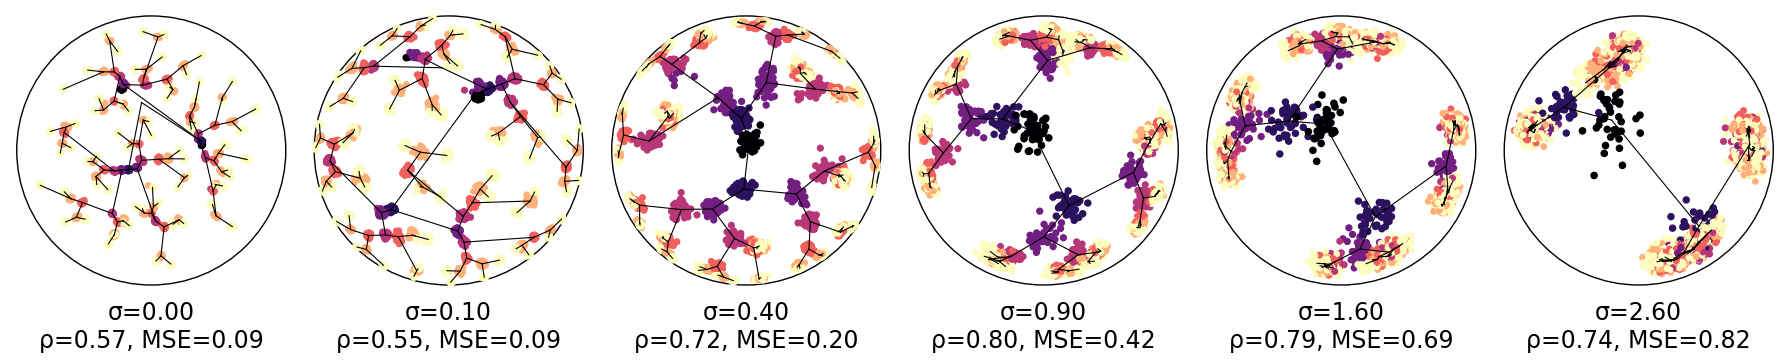

In [16]:
# subset of first 6 noise levels
subset = metrics

# precompute depth for coloring & sizing
positive_labels = np.where(train_data.labels >= 0, train_data.labels, 0)
depths = np.sum(positive_labels > 0, axis=1)
point_sizes = np.maximum(20 - depths, 5)

fig, axes = plt.subplots(1, len(subset), figsize=(18, 5))
plt.subplots_adjust(wspace=0.02, bottom=0.18)

for ax, (std, pearson, mse) in zip(axes, subset):
    # get embedding & convert to Poincaré if needed
    zt = models[std].z.detach()
    zp = lorentz_to_poincare(zt)  # numpy array shape (N,2)

    # recompute per‐model means for each label to draw correct edges
    label_to_mean_pos = {}
    for lab in unique_labels:
        inds = np.where((positive_labels == lab).all(axis=1))[0]
        if inds.size > 0:
            label_to_mean_pos[tuple(lab)] = zp[inds].mean(axis=0)

    # draw unit‐disk boundary
    circle = plt.Circle((0, 0), disk_radius, edgecolor='black', fill=False)
    ax.add_artist(circle)

    # scatter colored by depth, sized by depth
    sc = ax.scatter(
        zp[:, 0], zp[:, 1],
        c=depths,
        s=point_sizes,
        alpha=1,
        cmap='magma',
    )

    # draw tree edges using this model's means
    for parent_label, child_label in edges:
        p = label_to_mean_pos[parent_label]
        c = label_to_mean_pos[child_label]
        ax.plot([p[0], c[0]], [p[1], c[1]], 'k-', linewidth=0.8)

    # fix limits/aspect
    if manifold.name == 'Lorentz':
        ax.set_xlim(-1.05 * disk_radius, 1.05 * disk_radius)
        ax.set_ylim(-1.05 * disk_radius, 1.05 * disk_radius)
    ax.set_aspect('equal')
    ax.set_xticks([]); ax.set_yticks([])

    # annotation just below plot, closer and larger font
    ax.text(
        0.5, -0.03,
        f"σ={std:.2f}\nρ={pearson:.2f}, MSE={mse:.2f}",
        transform=ax.transAxes,
        ha='center', va='top',
        fontsize=17
    )

plt.tight_layout()
# plt.savefig('results/pngs/synth_ablation_nooutline.png', dpi=300, bbox_inches='tight')
# plt.savefig('results/pdfs/synth_ablation_nooutline.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
curvatures = np.round(np.linspace(np.sqrt(0.1), np.sqrt(29), 6) ** 2, 1)
noise_levels = np.round(np.linspace(0, np.sqrt(5), 8) ** 2, 1)[:-2]
print("Noise levels (std):", noise_levels)
print("Curvatures (c):", curvatures)

dim_list = [3, 16, 32, 64, 128, 256, train_data.data.shape[1]]

models = {}
metrics = []

for c in curvatures:
    manifold = geoopt.manifolds.Lorentz(k=c)
    for std in noise_levels:
        print(f"\nTraining c={c:.1f}, σ={std:.1f} …")
        set_all_seeds(0)
        model = RGD(dim_list, manifold)
        model.z = model.init_samples(len(train_data))
        model.z_val = model.init_samples(len(val_data))
        train_rgd(
            model, F.mse_loss, train_loader, val_loader,
            [1e-1, 2e-3], betas=(0.9,0.995),
            n_epochs=800, device=device, print_loss_step=5,
            patience=85, start_saving=150, wd=1e-3,
            noise_std=std
        )
        models[(c, std)] = model
        zt = model.z.detach()
        p, _ = calculate_correlation_metrics_branching(zt, manifold, train_data)
        _, mse = calculate_reconstruction_metrics(model, zt, train_data)
        metrics.append((c, std, p, mse))

# Save models
# for (c, std), model in models.items():
#     torch.save(model.state_dict(), f'models/synthetic_tree_c{c:.1f}_std{std:.1f}.pt')
#     print(f"Saved model with c={c:.1f}, std={std:.1f} at path: models/synthetic_tree_c{c:.1f}_std{std:.1f}.pt")



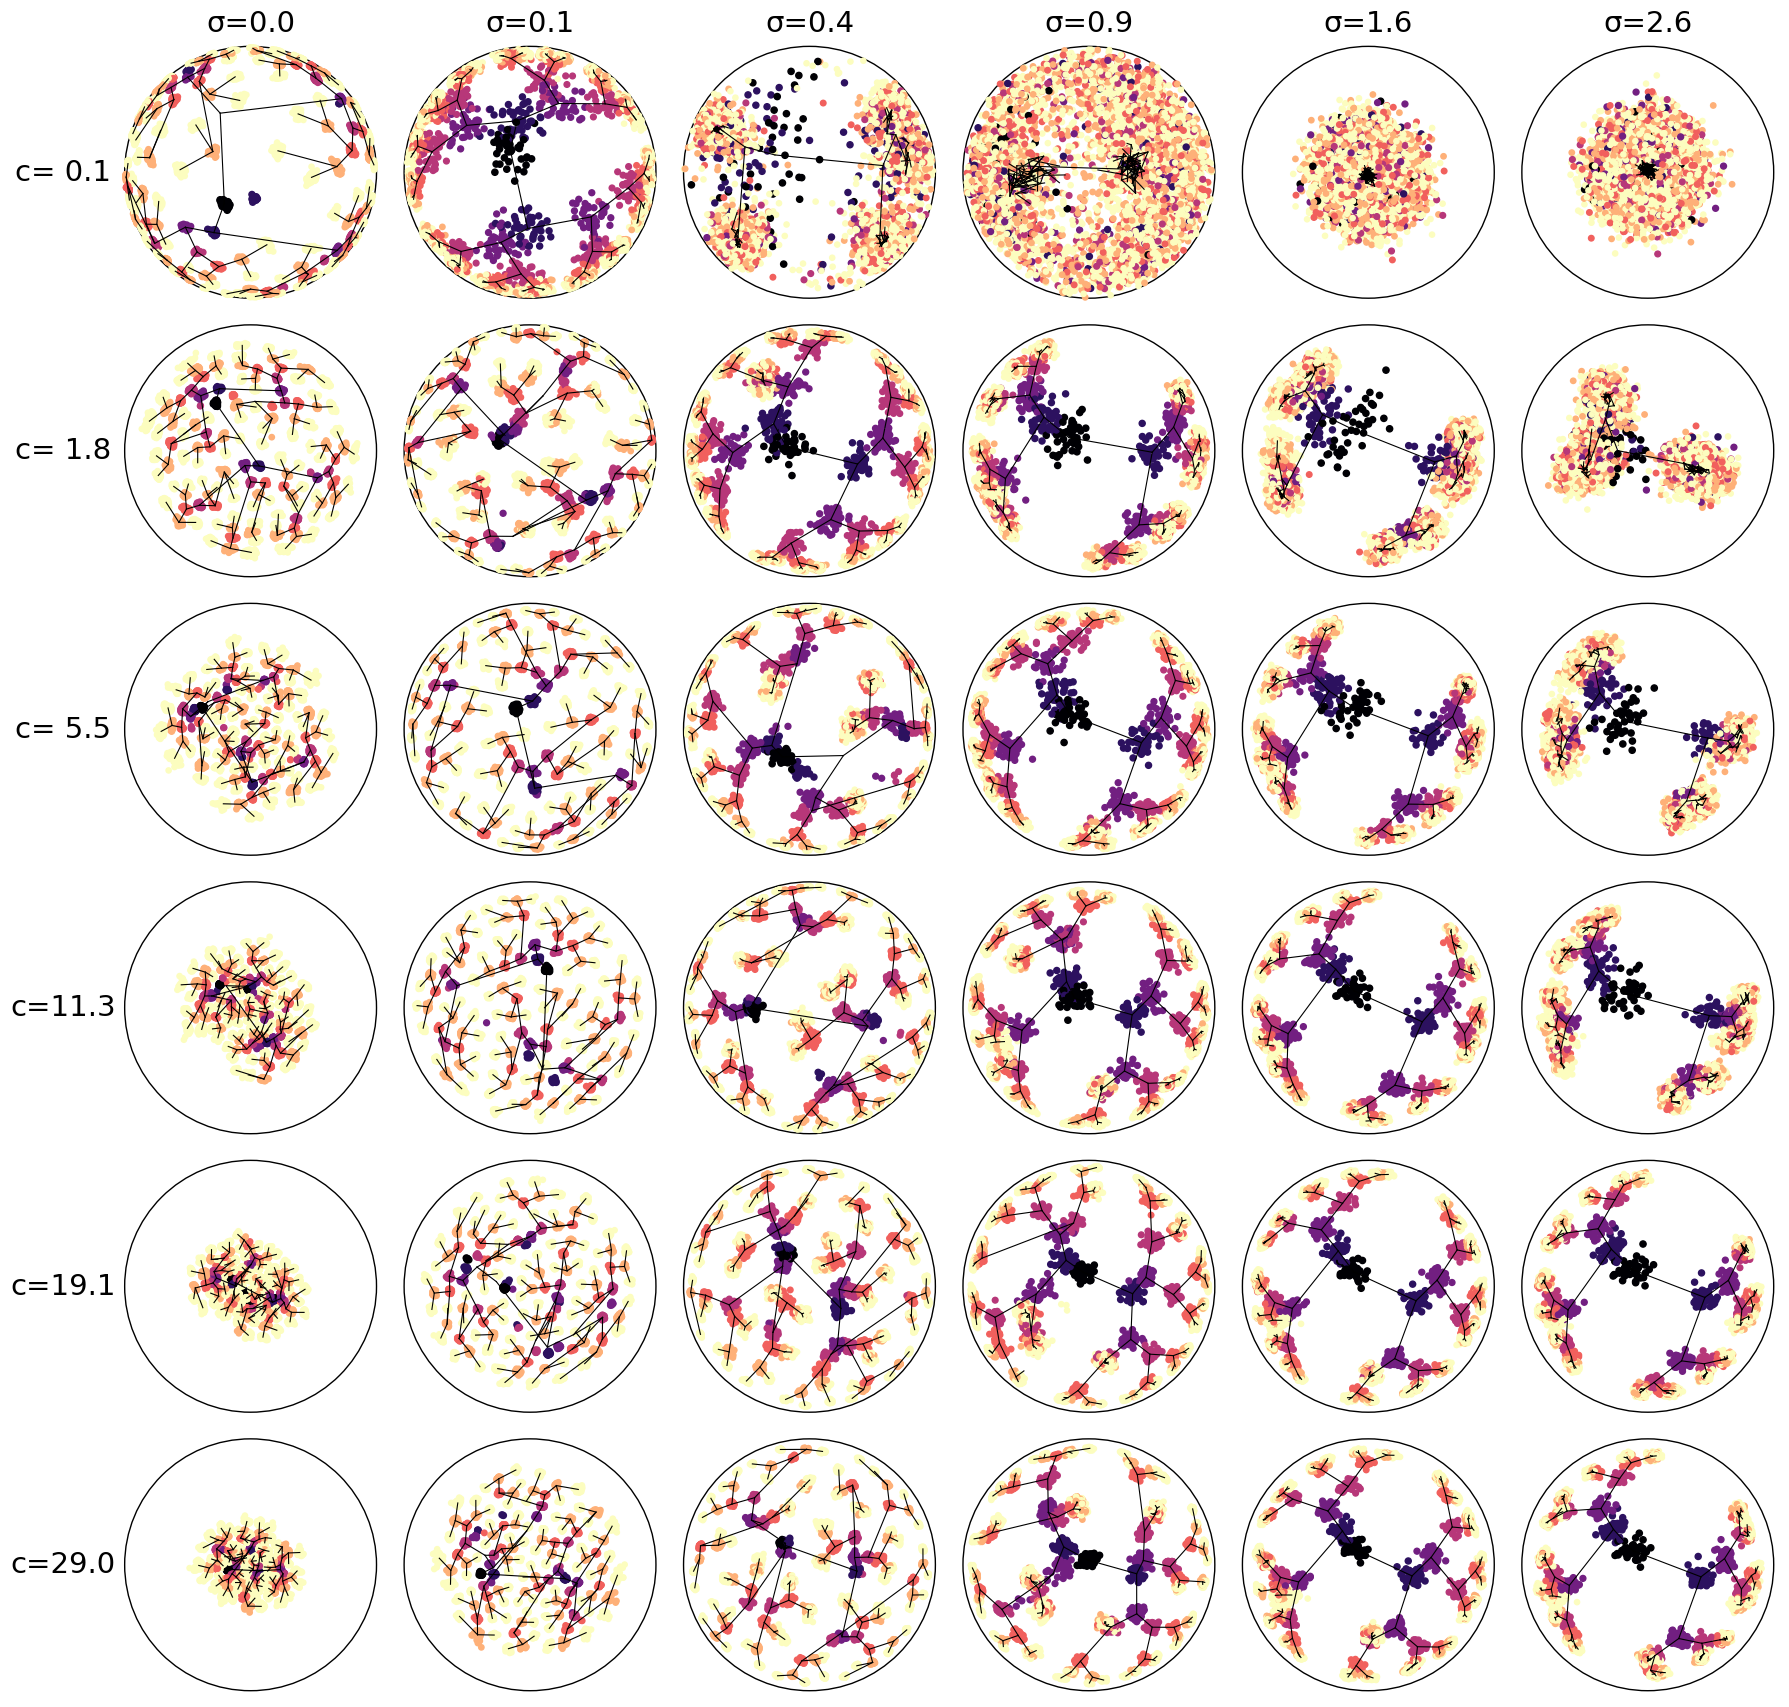

In [18]:
disk_radius = 1

# precompute label‐based colouring/sizes/edges (same for all models)
l = train_data.labels * (train_data.labels >= 0)
_, ys = np.unique(np.where(l>0, l, 0), axis=0, return_inverse=True)
levels = np.sum(np.where(l>0, l, 0)>0, axis=1)
point_sizes = np.clip(16 - levels, 5, 16)

# build static edge list of (parent_label_tuple, child_label_tuple)
unique_labels = np.unique(np.where(l>0, l, 0), axis=0)
edges = []
for lab in unique_labels:
    nz = np.nonzero(lab)[0]
    if nz.size:
        parent = lab.copy()
        parent[nz[-1]] = 0
        pt = tuple(parent)
        ct = tuple(lab)
        if any((unique_labels == parent).all(axis=1)):
            edges.append((pt, ct))

positive_labels = np.where(train_data.labels >= 0, train_data.labels, 0)
depths = np.sum(positive_labels > 0, axis=1)
point_sizes = np.maximum(20 - depths, 5)

fig, axes = plt.subplots(len(curvatures), len(noise_levels), figsize=(18, 18))
plt.subplots_adjust(wspace=0.0, hspace=-0.4, )#bottom=0.1, left=0.1)

for i, c in enumerate(curvatures):
    for j, std in enumerate(noise_levels):
        ax = axes[i, j]
        zp = lorentz_to_poincare(models[(c, std)].z.detach())
        label_to_mean_pos = {
            tuple(lab): zp[np.where((positive_labels == lab).all(axis=1))].mean(0)
            for lab in unique_labels if np.any((positive_labels == lab).all(axis=1))
        }
        circle = plt.Circle((0, 0), disk_radius, edgecolor='black', fill=False)
        ax.add_artist(circle)
        ax.scatter(zp[:, 0], zp[:, 1], c=depths, s=point_sizes, cmap='magma')
        for parent, child in edges:
            ppos, cpos = label_to_mean_pos[parent], label_to_mean_pos[child]
            ax.plot([ppos[0], cpos[0]], [ppos[1], cpos[1]], 'k-', linewidth=0.8)
        ax.set_aspect('equal')
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlim(1.05 * -disk_radius, 1.05 * disk_radius); ax.set_ylim(1.05 * -disk_radius, 1.05 * disk_radius)
        if i == 0: ax.set_title(f"σ={std:.1f}", fontsize=21)
        if j == 0: ax.set_ylabel(f"c={c:4.1f}", fontsize=21, rotation=0, labelpad=40, va='center')

# fig.text(0.5, 1, 'Noise level', ha='center', fontsize=24)
# fig.text(-0.02, 0.5, 'Curvature', va='center', rotation='vertical', fontsize=24)

plt.tight_layout()
# plt.savefig('results/pngs/app_synth_ablation_c_std_lowdpi.png', dpi=200, bbox_inches='tight')
# plt.savefig('results/pdfs/app_synth_ablation_c_std_lowdpi.pdf', dpi=200, bbox_inches='tight')
plt.show()
